In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

#from MEM_class import MEM

#from synthData_Gen import SyntheticData_Gen

Load all cores available.

In [2]:
milcent = pd.read_csv('../Data/datasets/Milcent/milcent1973detail.txt', ',')[1:]

crete = pd.read_csv('../Data/datasets/Alphabet_cores/crete_det.txt',' ')[1:]

SiteA = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteA_det.txt', ' ')[1:]
SiteB = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteB_det.txt', ' ')[1:]
SiteD = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteD_det.txt', ',')[1:]
SiteE = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteE_det.txt', ' ')[1:]
SiteF = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteF_det.txt', ',')[1:]
SiteG = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteG_det.txt', ' ')[1:]
SiteH = pd.read_csv('../Data/datasets/Alphabet_cores/AlfabetFromBo/SiteH_det.txt', ',')[1:]

B19 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B19.txt', '\t')
B22 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B22.txt', '\t')
B23 = pd.read_csv('../Data/datasets/B_cores_AWI/AWI_Bcores__Cleaned_CSV/Depth_d18O__B23.txt', '\t')


#AllData = {'milcent': milcent, 'crete': crete, 'SiteA': SiteA, 'SiteB': SiteB, 'SiteD': SiteD, \
#          'SiteE': SiteE, 'SiteF': SiteF, 'SiteG': SiteG, 'SiteH': SiteH, 'B19': B19, 'B22': B22, 'B23': B23}

AllData = {'crete': crete, 'SiteA': SiteA, 'SiteB': SiteB, 'SiteD': SiteD, \
          'SiteE': SiteE, 'SiteG': SiteG, 'B19': B19, 'B22': B22, 'B23': B23}

CoreNames = ['crete','SiteA','SiteB','SiteD','SiteE','SiteG','B19','B22','B23']
CoreColors = ['slategray','indianred', 'orangered','darkslategray', 'slategray', 'cadetblue', 'darkseagreen', 'tan', 'rosybrown']

Plot cores

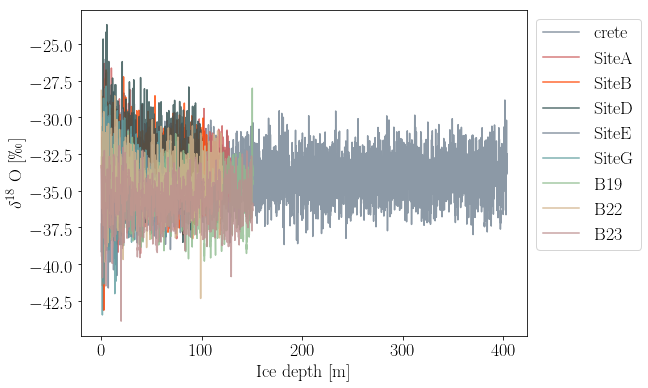

In [138]:
figCores, axCores = plt.subplots(figsize=(8,6))

for core, col in zip(CoreNames, CoreColors):
    axCores.plot(AllData[core]['depth'], AllData[core]['d18O'], alpha = 0.8,color=col, label = core)
    
axCores.set(xlabel='Ice depth [m]', ylabel='$\delta ^{18}$ O [\permil]')
axCores.legend(bbox_to_anchor=(1,1))

Define the min and max values corresponding to Laki and Tambora depth in core.

In [139]:
valsMin = [64.70, 70.90, 73.00, 81.50, 53.40, 60.50, 32.58, 45.44, 39.48]
valsMax = [74.74, 80.85, 83.70, 93.80, 62.95, 69.40,37.12, 52.04, 45.38]

Compute a new depth array with evenly spaced entries through interpolation. New sampling size corresponds to smallest sample size in examined series.

Plot the cores and their interpolations with the same starting point (at x = 0).

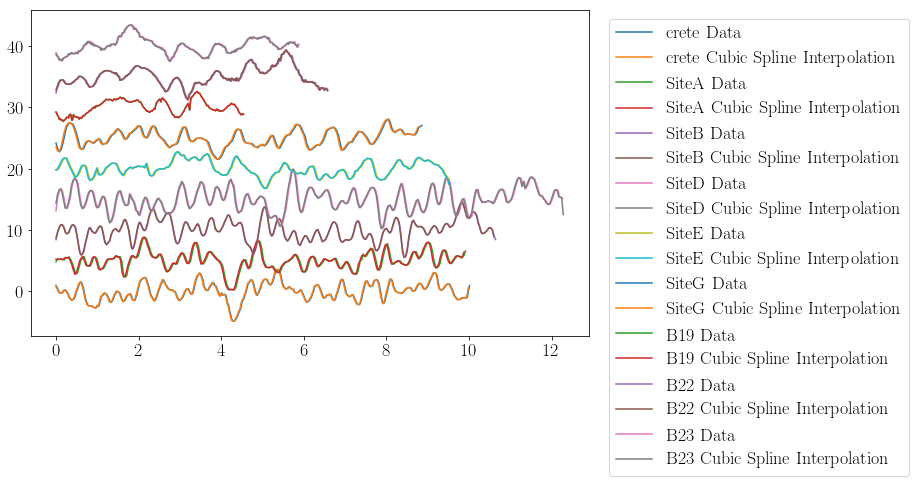

In [140]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(1,n+1,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat

fig, ax = plt.subplots(figsize=(10,6))
add = [0,5,10,15,20,25, 30, 35, 40]
for core, i in zip(CoreNames, range(len(CoreNames))):
    depthUse = AllData[core]['depth'] 
    d18OUse = AllData[core]['d18O']
    dhat, xhat = interpCores(valsMin[i], valsMax[i], depthUse, d18OUse)
    
    d18O_int = xhat - np.mean(xhat) + add[i]
    dep_int = dhat
    dep_int = dep_int - dep_int[0]
    
    d18O_U =  d18OUse[(depthUse >= valsMin[i]) & (depthUse <= valsMax[i])]#data['d18O'][(data['depth'] > valMin) & (data['depth'] < valMax)]
    d18O = d18O_U - np.mean(d18O_U) + add[i]
    dep = depthUse[(depthUse >= valsMin[i]) & (depthUse <= valsMax[i])]#data['depth'][(data['depth'] > valMin) & (data['depth'] < valMax)]
    dep = dep - dep.values[0]

    ax.plot(dep, d18O, label=core + ' Data')
    ax.plot(dep_int, d18O_int, label=core + ' Cubic Spline Interpolation')
    ax.legend()
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
#ax.set(xlim=(min(valsMin), max(valsMax)));

Define what core to look at - along with its Laki and Tambora locations.

In [147]:
coreName = 'SiteG'
idx = CoreNames.index(coreName)
valMin = valsMin[idx]
valMax = valsMax[idx]

depth = np.asarray(AllData[coreName]['depth'])#s1[4]#
depth_in = depth[(depth >= valMin) & (depth <= valMax)]

data = np.asarray(AllData[coreName]['d18O'])#s1[5]#
data_in = data[(depth >= valMin) & (depth <= valMax)]

dt = depth_in[1] - depth_in[0]
N = data_in.size


Create an instance of deconcolution of data

In [148]:
from Decon import SpectralDecon
decon_inst = SpectralDecon(depth_in, data_in, 2000)

Create and plot spectrum figure and axis.

In [150]:
a,b = decon_inst.plotSpectrum(showFig=False)


Using default boundaries for variance and a1
Diff. len., fit [cm]: 8.671


Show spectrum figure

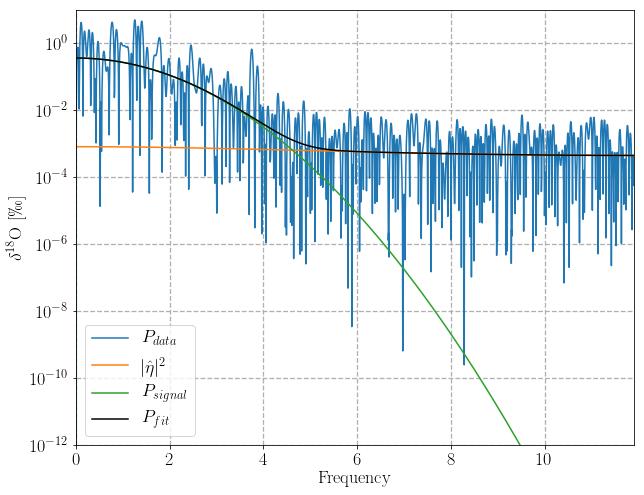

In [151]:
a

Create a list of different diffusion lengths to deconvolve with.

In [152]:
sigma_in = np.linspace(0.065,0.11,10)
sigma_in

array([0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095, 0.1  , 0.105,
       0.11 ])

Compute the filters given the certain diffusion length.

In [126]:
c = []

for i in range(len(sigma_in)):
    c.append(decon_inst.Filters(sigma=sigma_in[i]))


Plot filters for all different diffusion lengths.

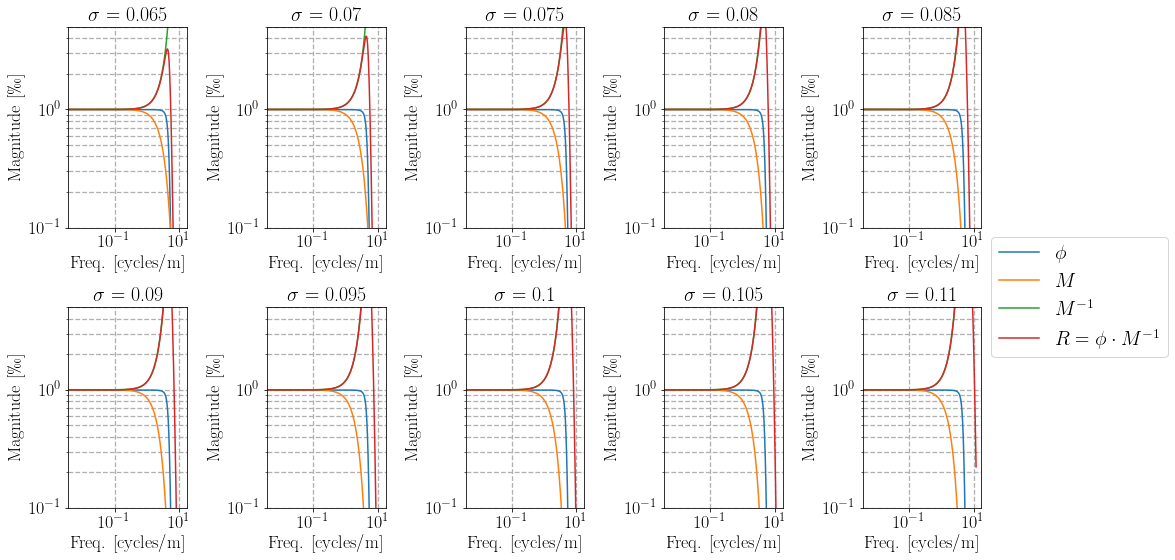

In [127]:
fig, axes = plt.subplots(2,5,figsize=(14,8))
plt.rcParams.update({'font.size': 14})

axes.titlesize:'x-large'
#plt.rcParams.update({'title.size': 18})
for i, ax in zip(range(len(sigma_in)), axes.flatten()):
    ax.grid(linestyle='--',lw=1.3, which='both')
    ax.loglog(c[i][0], c[i][1])
    ax.loglog(c[i][0], c[i][2])
    ax.loglog(c[i][0], c[i][2]**(-1))
    ax.loglog(c[i][0], c[i][3])
    ax.set_title('$\sigma$ = ' + str(round(sigma_in[i],3)),fontsize=20)
    ax.set(ylim=(1e-1,5), xlabel='Freq. [cycles/m]', ylabel='Magnitude [\permil]')
    

ax.legend(labels= ['$\phi$', '$M$', '$M^{-1}$', '$R = \phi \cdot M^{-1}$'],bbox_to_anchor=(1,1.4), fontsize=20)
fig.tight_layout()

Compute the deconvoluted restored data for each sigma.

In [128]:
e = []

for i in range(len(sigma_in)):
    e.append(decon_inst.deconvolve(sigma=sigma_in[i]))


Plot all restored data given certain diff. len.

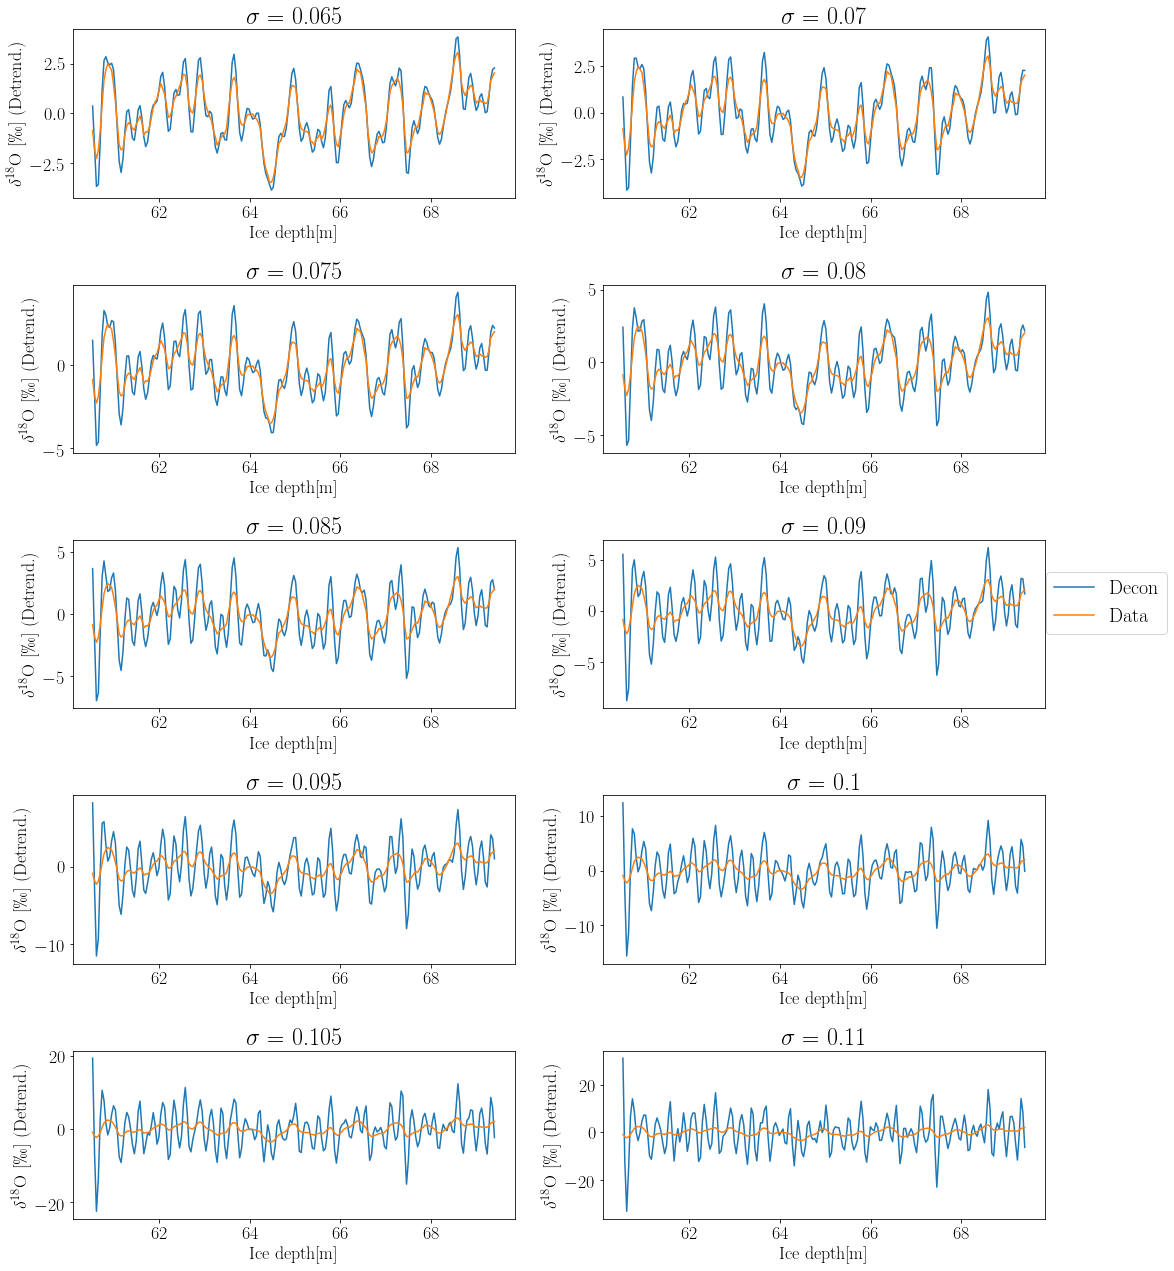

In [153]:
figDecon, axesDecon = plt.subplots(5,2,figsize=(15,18))
plt.rcParams.update({'font.size': 18})
axes.titlesize:'x-large'

for i, ax in zip(range(len(sigma_in)), axesDecon.flatten()):
    ax.plot(e[i][0], e[i][1])
    ax.plot(depth_in, data_in-np.mean(data_in))
    ax.set_title('$\sigma$ = ' + str(round(sigma_in[i],3)),fontsize=24)
    ax.set(xlabel='Ice depth[m]', ylabel='$\delta ^{18}$O [\permil] (Detrend.)')
    

ax.legend(labels= ['Decon', 'Data'],bbox_to_anchor=(1.3,3.9), fontsize=20)
figDecon.tight_layout()

Choose which diffusion lengths to actually use.

In [130]:
sigma_in_use = sigma_in[sigma_in < 0.10]


Plot restored signal for all chosen sigma in same plot.

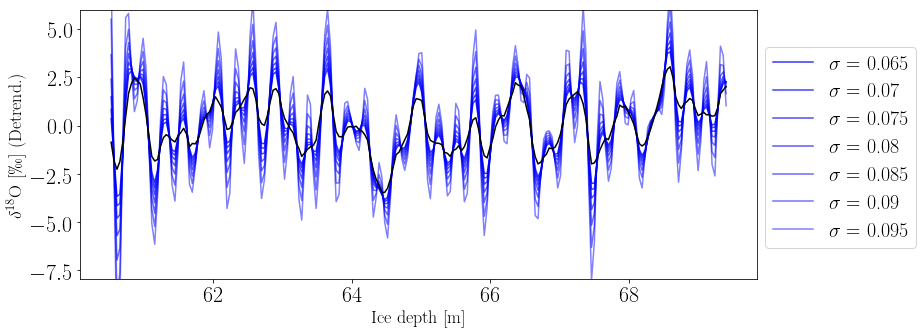

In [131]:
alphas = np.linspace(0.5,0.8,len(sigma_in_use))[::-1]

figDecon1, axDecon1 = plt.subplots(figsize=(11,5))


for i in range(len(sigma_in_use)):
    axDecon1.plot(e[i][0], e[i][1], label='$\sigma = $ ' + str(round(sigma_in_use[i],3)), alpha=alphas[i], color='blue')
axDecon1.plot(depth_in, data_in-np.mean(data_in), color='k')

axDecon1.tick_params(axis='both', which='major', labelsize=22)
axDecon1.set(ylim=(-8,6), xlabel='Ice depth [m]', ylabel='$\delta ^{18}$O [\permil] (Detrend.)')
axDecon1.legend(bbox_to_anchor=(0.75,0.4,0.5,0.5), fontsize=20)
figDecon1.tight_layout()

Generate a time series of synthetic data through an AR1 process:

In [32]:
#s1_instance = SyntheticData_Gen(AR1_coef = 0.3, AR1_var = 120, AR1_dt = 0.001, AR1_N = 20000, diff_len=0.08, dt_sample = 0.02, meas_noise = 0.03)
#s1 = s1_instance()

Plot said time series, both raw AR1 process and sampled/diffused series.

In [33]:
#plotFig = True
#if plotFig:
#    figSynth, axSynth = plt.subplots(figsize=(12,6))
#    axSynth.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
#    axSynth.plot(s1[2],s1[3],linewidth=0.8, color='blue', alpha=0.9,label='Before diffusion')
#    axSynth.plot(s1[4],s1[5], color='black', label='After diffusion')
#    axSynth.legend()
#    figSynth.savefig('SynthData.png')

Plot only the sampled/diffused data.

In [19]:
#if plotFig:
#    figSynthDiff, axSynthDiff = plt.subplots(figsize=(12,6))
#    axSynthDiff.set(xlim=(0,20), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]', title='Synthetic data, after diffusion')
#    axSynthDiff.plot(s1[4],s1[5], color='black')
#